# API based SageMaker Lineage Entity Creation
### Please place this notebook in a seperated folder since it will generate multiple files and folders.

* Please reach out to Yuyao Zhang ozhang@amazon.com or Melanie Li mmelli@amazon.com for any issue or questions

In this notebook, we are assuming the context as shown in the image. There is a root account which hosting all model packages, model artifacts as well as SageMaker Project/CodePipeline. The model will be deployed to staging and prod accounts after training & validation in root account. This is from AWS [blog](https://aws.amazon.com/blogs/machine-learning/multi-account-model-deployment-with-amazon-sagemaker-pipelines/)
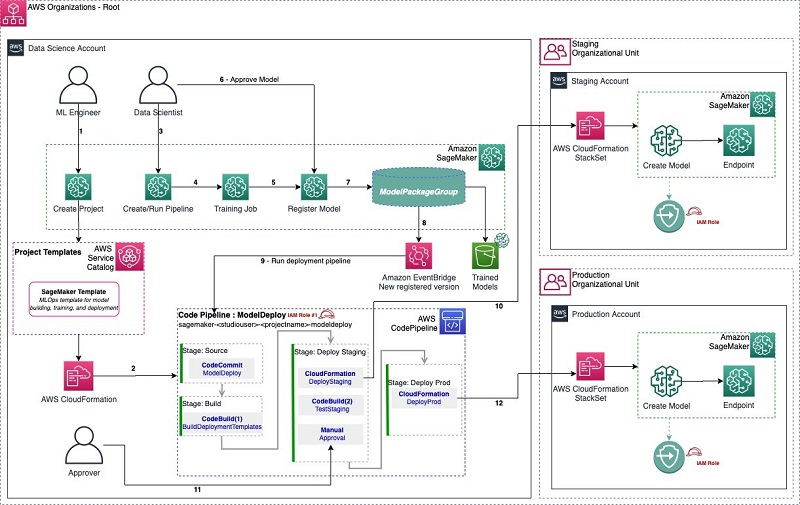



SageMaker Studio's Model Registry just list and show all actions associated with the current model packages. To implement `CreateModel` based registry records, we just need to create an `CreateModel` action and then associate this action with the corresponding model pakcages. In the following figure, we illustrate the general work flow. When user issues CreateModel API, CloudTrail will record this API and then trigger a pre-defined rule in EventBridge, which then run a Lambda function to create the action and associate the action with the model package. This model creation event would then be shown in SageMaker Studio.

This figure shows the same account setup. We could easily extens this setting to cross account setup by sending CloudTrail event from Prod account to the root accout.

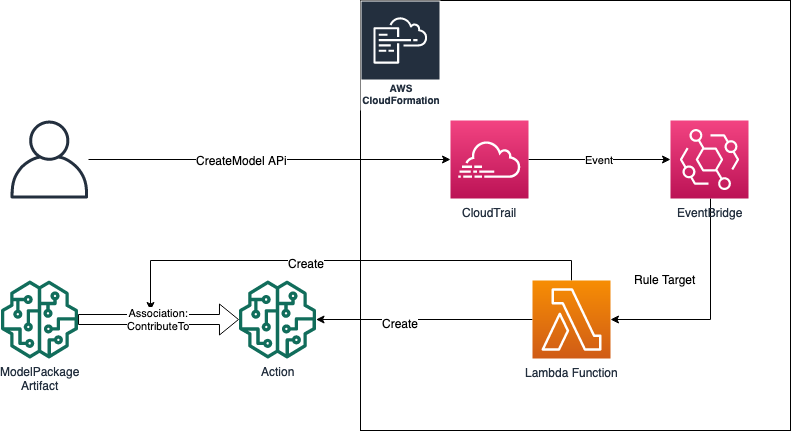

## Lambda Function to be triggered for Action Creation and Association
This function only runs in root account. For Prod/Staging account, they only capture CloudTrail events and forward them to the root for processing. 

In [108]:
%%writefile ./lambda/lambda_function.py

# Python Built-Ins:
import json
import logging
import time

# External Dependencies:
import boto3

from sagemaker.lineage.action import Action
from sagemaker.lineage.association import Association
from sagemaker.lineage.artifact import Artifact


logger = logging.getLogger("main")
logger.setLevel(logging.INFO)
smclient = boto3.client("sagemaker")

def lambda_handler(event, context):
    logger.debug("Received: %s", event)
    
    # Sample event
#     {
#     "region": "ap-southeast-2",
#     "account": "1234567890",
#   	"requestParameters": {"modelName":"2-2022-05-21-12-56-16-475","containers":[{"modelPackageName":"arn:aws:sagemaker:ap-southeast-2:1234567890:model-package/project-p-6dvnevzoh2mt/2"}],"executionRoleArn":"arn:aws:iam::1234567890:role/service-role/AmazonSageMakerServiceCatalogProductsUseRole","enableNetworkIsolation":false}
#     }
    
    tp_keys = ['requestParameters', 'region', 'account']
    tp_prp = {}
    for prp_name in tp_keys:
        tp_prp[prp_name] = event.get(prp_name, event.get(prp_name.capitalize()))
        if tp_prp[prp_name] is None:
            raise ValueError(
                f"Input event must include top-level property '{prp_name}' (or '{prp_name.capitalize()}')"
            )
    
    model_name = tp_prp['requestParameters'].get("modelName", tp_prp['requestParameters'].get("ModelName"))
    if model_name is None:
        raise ValueError(
            f"Input property 'requestParameters' must include property 'modelName' (or 'ModelName')"
        )
    action_params = {"action_name":model_name+'-'+str(int(time.time())),
                     "action_type":"ModelDeployment",
                     "source_uri":f"sagemaker:{tp_prp['region']}:{tp_prp['account']}:model/"+model_name,
                     "properties":{"ModelName":model_name}
                    }        
    create_model_action = Action.create(**action_params)

    
    containers_obj = tp_prp['requestParameters'].get("containers", tp_prp['requestParameters'].get("Containers"))
    for ctn_obj in containers_obj:
        
        model_package_arn = ctn_obj.get("modelPackageName", ctn_obj.get("ModelPackageName"))
        if model_package_arn is None:
            raise ValueError(
                f"Input property 'requestParameters' must include property 'modelPackageName' (or 'ModelPackageName')"
            )

        logger.info(f"Processing lineage for CreateModel on {model_package_arn}")

        ### Start creating lineage action using information from createmodel + adding associations
        # aws sagemaker update-action --action-name woodside-new-staging-1652279310-1-aws-model --properties ModelName=model-oaaqiwhdk5fj,DeploymentStage=staging
        # aws sagemaker add-association --source-arn arn:aws:sagemaker:ap-southeast-2:607162686141:artifact/36720f10445785208a9954a29ea7c32c --destination-arn arn:aws:sagemaker:ap-southeast-2:607162686141:action/woodside-new-staging-1652279310-1-aws-model --association-type ContributedTo    
        # aws sagemaker update-action --action-name woodside-new-staging-1652279310-1-aws-model --action-type ModelDeployment --source SourceUri=arn:aws:sagemaker:ap-southeast-2:607162686141:model/model-oaaqiwhdk5fj,SourceType=ARN,SourceId=1 --properties ModelName=model-oaaqiwhdk5fj,DeploymentStage=staging --metadata-properties ProjectId=p-6dvnevzoh2mt

        model_pkg_artifacts = Artifact.list(source_uri=model_package_arn)
        
        for artifact_idx in model_pkg_artifacts:
            action_action_association = Association.create(
                source_arn=artifact_idx.artifact_arn,
                destination_arn=create_model_action.action_arn,
                association_type="ContributedTo")

Overwriting ./lambda/lambda_function.py


The following script will prepare Lambda environment and code into a Zip file and upload it to S3. Please make sure zip is available in the environment or this will fail. 

Please fill in the following two vairables to define the staging S3 path.

In [110]:
bucket_name = 'sagemaker-ap-southeast-2-607162686141'
zip_prefix = 'some/path/my-deployment-package.zip'

In [ ]:
%%sh
mkdir -p ./lambda
cd lambda/
pip install --target ./package sagemaker
cd package
zip -r ../my-deployment-package.zip .
cd ..
zip -g my-deployment-package.zip lambda_function.py

In [111]:
!aws s3 cp ./lambda/my-deployment-package.zip s3://$bucket_name/$zip_prefix

upload: lambda/my-deployment-package.zip to s3://sagemaker-ap-southeast-2-607162686141/some/path/my-deployment-package.zip


## CloudFormation Template to be Deployed in Root Account

In [87]:
%%writefile root-account-template.yaml
---
AWSTemplateFormatVersion: '2010-09-09'

Description: >-
  Create SageMaker Lineage based on CreateModel API call via CloudTrail.
Parameters:
  LambdaFuncS3BucketName:
    Type: String
    Description: Bucket name of code for Lambda function
  LambdaFuncS3Prefix:
    Type: String
    Description: S3 path to the code file in S3 bucket.
        
Resources:
  # Access role for the Lambda function
  CreateModelLineageLambdaRole:
    Type: 'AWS::IAM::Role'
    Properties:
      AssumeRolePolicyDocument:
        Version: '2012-10-17'
        Statement:
          - Effect: Allow
            Principal:
              Service:
                - lambda.amazonaws.com
            Action:
              - 'sts:AssumeRole'
      ManagedPolicyArns:
        - 'arn:aws:iam::aws:policy/service-role/AWSLambdaBasicExecutionRole'
      Policies:
        - PolicyName: SageMakerAccess
          PolicyDocument:
            Version: '2012-10-17'
            Statement:
              - Sid: SageMakerLineageAccess
                Effect: Allow
                Action:
                  - 'sagemaker:CreateAction'
                  - 'sagemaker:AddAssociation'
                  - 'sagemaker:ListArtifacts'
                Resource:
                  - '*'

  # Lambda definition itself
  CreateModelLineageFunction:
    Type: 'AWS::Lambda::Function'
    Properties:
      Description: Run commands upon SageMaker CreateModel API call to create SageMaker Lineage entities.
      Code:
        S3Bucket:
          Ref: LambdaFuncS3BucketName
        S3Key:
          Ref: LambdaFuncS3Prefix            
        # S3ObjectVersion: ${b}
      Handler: lambda_function.lambda_handler
      Role: !GetAtt CreateModelLineageLambdaRole.Arn
      Runtime: python3.7
      Timeout: 900

  #### SECTION: Triggering the Lambda Automatically
  # Until SageMaker directly supports EventBridge events on 'apps' (as notebook instance statuses already are), we can
  # work around this by triggering the function via a CloudTrail. 


  # CloudWatch events needs permission to actually invoke the above Lambda
  CloudWatchEventRole:
    Type: AWS::IAM::Role
    Properties:
      AssumeRolePolicyDocument:
        Version: '2012-10-17'
        Statement:
          - Effect: Allow
            Principal:
              Service:
                - events.amazonaws.com
            Action: sts:AssumeRole
      Path: /
      Policies:
        - PolicyName: RunLambda
          PolicyDocument:
            Version: '2012-10-17'
            Statement:
              - Effect: Allow
                Action: 'lambda:InvokeFunction'
                Resource: !GetAtt CreateModelLineageFunction.Arn

  # Finally, the rule controls how CloudTrail-logged events trigger the Lambda
  CloudWatchEventRule:
    Type: 'AWS::Events::Rule'
    Properties:
      EventPattern:
        source:
          - aws.sagemaker
        detail-type:
          - 'AWS API Call via CloudTrail'
        detail:
          eventSource:
            - sagemaker.amazonaws.com
          eventName:
            - CreateModel
          requestParameters:
            containers:
              modelPackageName:
              - exists: true
      Targets:
        - Arn: !GetAtt CreateModelLineageFunction.Arn
          Id: api-based-createmodel-lineage-non-root
          # Lambda will receive just the camelCased API request parameters, as per:
          # https://docs.aws.amazon.com/sagemaker/latest/dg/logging-using-cloudtrail.html
          # https://docs.aws.amazon.com/sagemaker/latest/APIReference/API_CreateApp.html
        # The transformed event will be something like the following one, which is from cross account    
        # {
        #   region:"ap-southeast-2",
        #   account:"0123456789",
        #   requestParameters:{
        #     modelName:"2-2022-05-22-11-55-15-260",
        #     containers:[
        #       {
        #         modelPackageName:"arn:aws:sagemaker:ap-southeast-2:9876543210:model-package/woodside-project/2"
        #       }
        #     ],
        #     executionRoleArn:"arn:aws:iam::0123456789:role/service-role/AmazonSageMaker-ExecutionRole-20220522T213009",
        #     enableNetworkIsolation:false
        #   }
        # }
          InputTransformer: 
            InputTemplate: "{\n    \"region\": <region>,\n    \"account\": <account>,\n  \t\"requestParameters\":
      <requestParameters>\n}"
            InputPathsMap:
              account: "$.account"
              region: "$.region"
              requestParameters: "$.detail.requestParameters"

  CloudWatchLambdaPermission:
    Type: 'AWS::Lambda::Permission'
    Properties:
      FunctionName: !GetAtt CreateModelLineageFunction.Arn
      Action: 'lambda:InvokeFunction'
      Principal: events.amazonaws.com
      SourceArn: !GetAtt CloudWatchEventRule.Arn

Overwriting root-account-template.yaml


This template assumes there is already a running CloudTrail trails, which in most cases there will be. If there is no existing trails, please incliuding the following section the above template to create a new trails and dedicated S3 bucket. Pleae note, this stack won't delete the created S3 bucket. Buckets need to be deleted manually if required.
```
# Here we create a new CloudTrail specifically for the
# purpose - but you could consider re-using an existing Trail if you have one.
  CloudTrailBucket:
    Type: 'AWS::S3::Bucket'
    DeletionPolicy: Retain            
    Properties:
      PublicAccessBlockConfiguration:
        BlockPublicAcls: true
        BlockPublicPolicy: true
        IgnorePublicAcls: true
        RestrictPublicBuckets: true

  CloudTrailBucketPolicy:
    Type: 'AWS::S3::BucketPolicy'
    Properties:
      Bucket: !Ref CloudTrailBucket
      PolicyDocument:
        Version: '2012-10-17'
        Statement:
          - Sid: AWSCloudTrailAclCheck
            Effect: Allow
            Principal:
              Service: cloudtrail.amazonaws.com
            Action: 's3:GetBucketAcl'
            Resource: !GetAtt CloudTrailBucket.Arn
          - Sid: AWSCloudTrailWrite
            Effect: Allow
            Principal:
              Service: cloudtrail.amazonaws.com
            Action: 's3:PutObject'
            Resource: !Sub '${CloudTrailBucket.Arn}/AWSLogs/${AWS::AccountId}/*'
            Condition:
              StringEquals:
                's3:x-amz-acl': 'bucket-owner-full-control'

  CloudTrail:
    Type: 'AWS::CloudTrail::Trail'
    DependsOn:
      - CloudTrailBucketPolicy
    Properties:
      EventSelectors: 
        - IncludeManagementEvents: true
          ReadWriteType: WriteOnly
      IncludeGlobalServiceEvents: false
      IsLogging: true
      IsMultiRegionTrail: false
      S3BucketName: !Ref CloudTrailBucket
      #TrailName: Use default
```

To deploy this CloudFormation, we also need to create an IAM role to CloudFormaton. The required permissions include `AmazonSageMakerFullAccess` and the following additional permissions as a minimal.
```
{
    "Version": "2012-10-17",
    "Statement": [
        {
            "Sid": "VisualEditor0",
            "Effect": "Allow",
            "Action": [
                "lambda:CreateFunction",
                "iam:GetRole",
                "events:DescribeRule",
                "lambda:InvokeFunction",
                "lambda:GetFunction",
                "events:PutRule",
                "iam:DeletePolicy",
                "iam:CreateRole",
                "iam:DeleteRole",
                "iam:AttachRolePolicy",
                "iam:PutRolePolicy",
                "iam:CreatePolicy",
                "events:PutTargets",
                "events:DeleteRule",
                "iam:PassRole",
                "iam:DetachRolePolicy",
                "lambda:AddPermission",
                "iam:DeleteRolePolicy",
                "lambda:DeleteFunction",
                "events:RemoveTargets",
                "iam:GetRolePolicy",
                "lambda:RemovePermission",
                "iam:DeletePolicyVersion"
            ],
            "Resource": "*"
        }
    ]
}
```
For template with new CloudTrail and S3 bucket, please add the following permissions in additional to `AmazonSageMakerFullAccess`
```

{
    "Version": "2012-10-17",
    "Statement": [
        {
            "Sid": "VisualEditor0",
            "Effect": "Allow",
            "Action": [
                "lambda:CreateFunction",
                "cloudtrail:StopLogging",
                "cloudtrail:StartLogging",
                "events:PutRule",
                "s3:CreateBucket",
                "iam:DeletePolicy",
                "iam:CreateRole",
                "iam:AttachRolePolicy",
                "iam:PutRolePolicy",
                "s3:GetBucketPolicy",
                "iam:PassRole",
                "iam:DetachRolePolicy",
                "iam:DeleteRolePolicy",
                "s3:PutBucketAcl",
                "events:RemoveTargets",
                "lambda:DeleteFunction",
                "s3:DeleteBucket",
                "s3:GetBucketPolicyStatus",
                "iam:GetRole",
                "events:DescribeRule",
                "cloudtrail:PutEventSelectors",
                "s3:PutBucketPublicAccessBlock",
                "lambda:InvokeFunction",
                "lambda:GetFunction",
                "iam:DeleteRole",
                "s3:DeleteBucketPolicy",
                "iam:CreatePolicy",
                "events:PutTargets",
                "events:DeleteRule",
                "lambda:AddPermission",
                "cloudtrail:DeleteTrail",
                "cloudtrail:CreateTrail",
                "s3:PutBucketPolicy",
                "lambda:RemovePermission",
                "iam:GetRolePolicy",
                "iam:DeletePolicyVersion"
            ],
            "Resource": "*"
        }
    ]
}
```

Using the following command, we could create a CloudFormation stack. This should be run in the root account. Please modify 
* `--template-body` with path to the generated template. If not change any code, this part could be left unchanged
* `--role-arn` with the just created role for CloudFormation using above-mentioned permissions.

In [112]:
!aws cloudformation create-stack \
  --stack-name SageMakerLineageExtention\
  --template-body file://./root-account-template.yaml \
  --parameters ParameterKey=LambdaFuncS3BucketName,ParameterValue=$bucket_name ParameterKey=LambdaFuncS3Prefix,ParameterValue=$zip_prefix \
  --role-arn arn:aws:iam::607162686141:role/SageMakerLineageCFNRole \
  --capabilities CAPABILITY_IAM                        

{
    "StackId": "arn:aws:cloudformation:ap-southeast-2:607162686141:stack/SageMakerLineageExtention/bf891080-dc2e-11ec-a31c-0aa88ffea9b2"
}


# Testing in Root Account

In [90]:
# Code used to create a model using a model package for testing
import sagemaker

model_package_arn = 'arn:aws:sagemaker:ap-southeast-2:607162686141:model-package/woodside-new-p-6dvnevzoh2mt/2'
role_arn = 'arn:aws:iam::607162686141:role/service-role/AmazonSageMakerServiceCatalogProductsUseRole'

sess = sagemaker.session.Session()
modelPkg = sagemaker.model.ModelPackage(model_package_arn=model_package_arn, 
                     role=role_arn,
                     sagemaker_session=sess)

# Create SageMaker Model now
modelPkg._create_sagemaker_model()

# CloudFormation Template to be deployed in Prod Account
In order for EventBridge to receive events from prod account, the following resource policy should be placed. We will need to replace corresponding parameters here.
```
{
  "Version": "2012-10-17",
  "Statement": [{
    "Sid": "allow_account_to_put_events",
    "Effect": "Allow",
    "Principal": {
      "AWS": "arn:aws:iam::<prod-account-id>:root"
    },
    "Action": "events:PutEvents",
    "Resource": "arn:aws:events:<region>:<root-account-id>:event-bus/default"
  }]
}
```

The following template should be deployed in prod acount to forward CreateModel API events to the Root acount for action creation and association. It may be easier to copy following code cells into a seprated notebook which could be executed in prod account.

Now, we could run `prod.ipynb` in prod account to deploy the event forwarding stack so that `CreateModel` events will be recognised in Root account.

# Security Considerations

This stack is provided as an example only, with some design decisions prioritizing simplicity. You may need to adapt it for specific cloud security policies in your organization (such as deploying the Lambda function in a VPC).

You may also want to identify `CreateModel` events from cross account. This couldbe achieved by adding account ID in `Properties`  in `CreateAction` API call as described [here](https://docs.aws.amazon.com/sagemaker/latest/APIReference/API_CreateAction.html#API_CreateAction_RequestSyntax). SageMaker Studio will show everything in `Properties` fields in UI.

It's also possible to monitor `CreateEndpoint` API call from cross account. This will need to add anothe rule to monitor `CreateEndpoint` and modify the Lambda function to create corresponding actions and associations. 